## Objective :
This project is made considering the Click Stream Data for the website provided. I have taken all factors into consideration. I have visualized the each feature of the data properly and considered only those features which are useful in making productions.
The main motivation behind this project is to find the anomalies in the Click Stream Data. 

## Algorithms Implemented :
* K-means clustering based anomaly detection  
* Elliptic Envelope on each category in data  
* Isolation Forest  
* One Class SVM (Support Vector Machine)  
* RNN (LSTM Neural Network)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from functions import *
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import random
%matplotlib inline

## Data Loading : 
Data is taken from the csv file. It is real time data taken from the website and given.

In [2]:
df_cluster = get_data()
df_cluster.head()

,height,width,time,type,scrollX,scrollY
0,810,1535,824.55,mouseover,0,0
1,810,1535,824.55,mousemove,0,0
2,810,1535,837.55,mousemove,0,0
3,810,1535,850.55,mousemove,0,0
4,810,1535,862.55,mousemove,0,0


In [3]:
types = df_cluster['type'].unique()
print(types)

['mouseover' 'mousemove' 'mouseout' 'scroll' 'mousedown' 'mouseup' 'click'
 'focusin' 'focusout' 'dblclick' 'unload']


In [4]:
df_cluster = add_dummies(df_cluster,types)
types_dict = {}
for key in types:
    types_dict[key] = df_cluster.columns.get_loc(key)
print(types_dict)

{'mousedown': 10, 'dblclick': 15, 'mouseup': 11, 'click': 12, 'focusout': 14, 'mouseover': 6, 'mouseout': 8, 'mousemove': 7, 'focusin': 13, 'unload': 16, 'scroll': 9}


In [5]:
df_cluster = assign_dummies(df_cluster,types_dict)
df_cluster.head()

,height,width,time,type,scrollX,scrollY,mouseover,mousemove,mouseout,scroll,mousedown,mouseup,click,focusin,focusout,dblclick,unload
0,810,1535,824.55,mouseover,0,0,1,0,0,0,0,0,0,0,0,0,0
1,810,1535,824.55,mousemove,0,0,0,1,0,0,0,0,0,0,0,0,0
2,810,1535,837.55,mousemove,0,0,0,1,0,0,0,0,0,0,0,0,0
3,810,1535,850.55,mousemove,0,0,0,1,0,0,0,0,0,0,0,0,0
4,810,1535,862.55,mousemove,0,0,0,1,0,0,0,0,0,0,0,0,0


In [6]:
# Deleting unnecessary columns which are not important for predictions.
df_cluster = remove_columns(df_cluster,['height','width','scrollX','type','unload'])

In [7]:
df_cluster.describe()

,time,scrollY,mouseover,mousemove,mouseout,scroll,mousedown,mouseup,click,focusin,focusout,dblclick
count,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000
mean,47366.367122,1521.928758,0.058187,0.386423,0.058560,0.470720,0.007460,0.007460,0.004476,0.002984,0.002238,0.000746
std,37667.370632,1147.213175,0.234141,0.487020,0.234844,0.499235,0.086064,0.086064,0.066765,0.054554,0.047263,0.027308
min,740.435000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11751.435000,810.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37830.550000,1235.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,83595.435000,2361.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,106672.515000,3740.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
X,df_cluster = scale_data(df_cluster)
df_cluster.head()

106672.515 740.435
3740.0 0.0


,time,scrollY,mouseover,mousemove,mouseout,scroll,mousedown,mouseup,click,focusin,focusout,dblclick
0,0.000794,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000794,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000917,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001039,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.001153,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Principle Component Analysis :
Before applying clustering algorithm, we have to compress the data in lesser dimension such that it is easy to cluster the data in different different groups. Here our original data dimension is 12 columns. We are applying this dimensionality reduction to make the dimension as 4 columns

In [9]:
pca = PCA(n_components=4)

In [10]:
principleComponents = pca.fit_transform(X)

In [11]:
principleDf = pd.DataFrame(data=principleComponents,columns=['PCA1','PCA2','PCA3','PCA4'])

In [12]:
principleDf.head()
print("Retention of data in Each Component : ",pca.explained_variance_ratio_)
print("Retention % of total data : ",sum(pca.explained_variance_ratio_)*100.0)

Retention of data in Each Component :  [ 0.51095446  0.15170327  0.12664289  0.10448304]
Retention % of total data :  89.3783664117


## K-means clustering Algorithm :
We are applying clustering algorithm on compressed data set. We are checking for different clusters so that we can visualize how the score for clusters varies on each k value in the algorithm

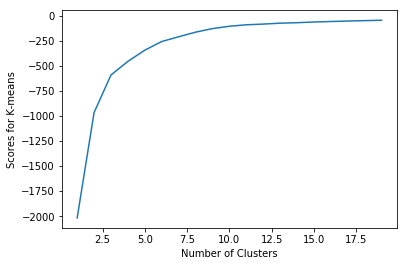

In [13]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(principleDf) for i in n_cluster]
scores = [kmeans[i].score(principleDf) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Scores for K-means')
plt.show()

In [15]:
df_cluster['cluster'] = kmeans[10].predict(principleDf)
df_cluster['PCA1'] = principleDf.iloc[:,0]
df_cluster['PCA2'] = principleDf.iloc[:,1]
df_cluster['PCA3'] = principleDf.iloc[:,2]
df_cluster['PCA4'] = principleDf.iloc[:,3]
df_cluster['cluster'].value_counts()

4     445
1     413
9     295
10    277
0     277
3     248
5     178
8     165
2     152
7     148
6      83
Name: cluster, dtype: int64

In [21]:
outliers_fraction = 0.01
distance = getDistanceByPoint(principleDf, kmeans[10])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df_cluster['anomaly'] = (distance >= threshold).astype(int)

C:\Users\Ashutosh\Desktop\Machine Learning Eckvation\Sample ML\sessions\functions.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  distance.set_value(i, np.linalg.norm(Xa-Xb))


In [22]:
df_cluster['anomaly'].value_counts()

0    2655
1      26
Name: anomaly, dtype: int64

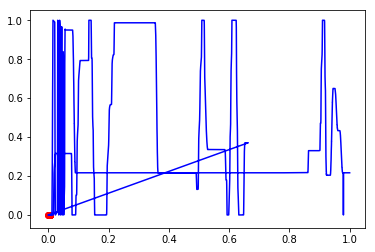

In [61]:
fig, ax = plt.subplots()

a = df_cluster.loc[df_cluster['anomaly'] == 1, ('time', 'scrollY')] #anomaly

ax.plot(df_cluster['time'], df_cluster['scrollY'], color='blue')
ax.scatter(a['time'],a['scrollY'], color='red')
plt.show()

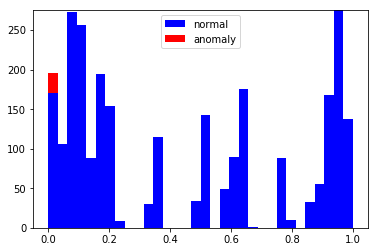

In [24]:
a = df_cluster.loc[df_cluster['anomaly'] == 0, 'time']
b = df_cluster.loc[df_cluster['anomaly'] == 1, 'time']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## Elliptic Envelope on Categories : 
We have 11 types of categories in our data like mouseover, mouseout, focusin, focusout etc. One or more of the given category may contribute to anomalies. This Algorithm is finding anomalies with respect to different categories.

In [25]:
df_ee = get_data()
df_ee.shape

(2681, 6)

##### All categorical anomalies depend upon two features, time and scrollY.

In [27]:
df_class0 = df_ee.loc[df_ee['type']=='mouseover',['time','scrollY']]
df_class1 = df_ee.loc[df_ee['type']=='mousemove',['time','scrollY']]
df_class2 = df_ee.loc[df_ee['type']=='mouseout',['time','scrollY']]
df_class3 = df_ee.loc[df_ee['type']=='scroll',['time','scrollY']]
df_class4 = df_ee.loc[df_ee['type']=='mousedown',['time','scrollY']]
df_class5 = df_ee.loc[df_ee['type']=='mouseup',['time','scrollY']]
df_class6 = df_ee.loc[df_ee['type']=='click',['time','scrollY']]
df_class7 = df_ee.loc[df_ee['type']=='focusin',['time','scrollY']]
df_class8 = df_ee.loc[df_ee['type']=='focusout',['time','scrollY']]
df_class9 = df_ee.loc[df_ee['type']=='dblclick',['time','scrollY']]
df_class10 = df_ee.loc[df_ee['type']=='unload',['time','scrollY']]

### Plots of each category w.r.t. time

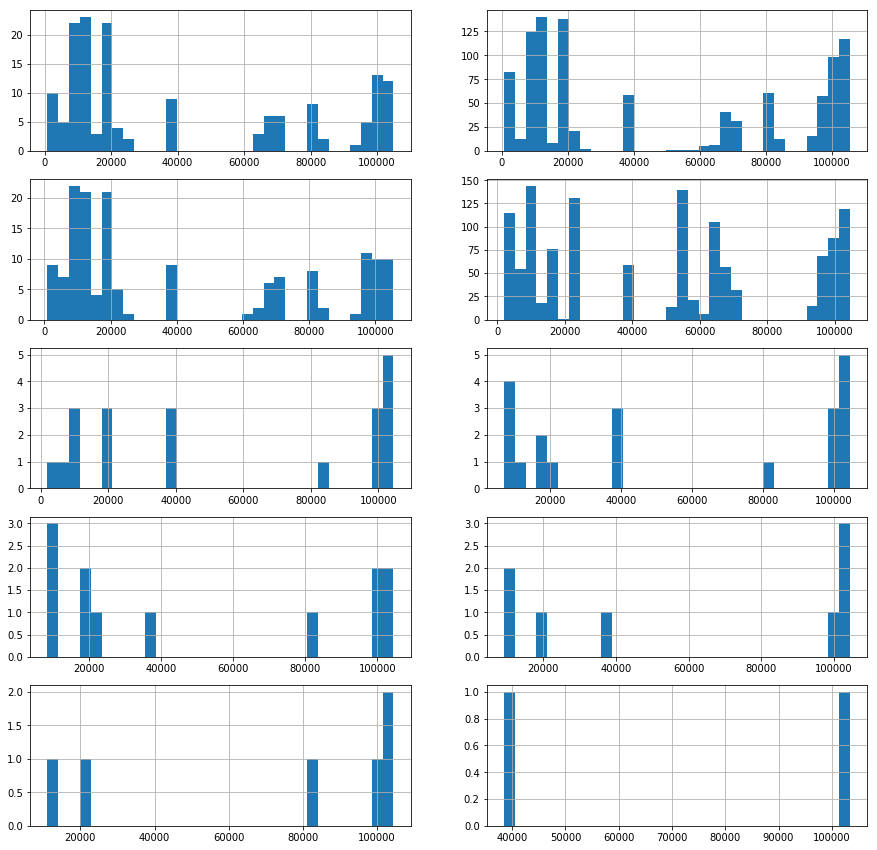

In [28]:
fig,axs = plt.subplots(5,2,figsize=(15,15))
df_class0['time'].hist(ax=axs[0,0],bins=32)
df_class1['time'].hist(ax=axs[0,1],bins=32)
df_class2['time'].hist(ax=axs[1,0],bins=32)
df_class3['time'].hist(ax=axs[1,1],bins=32)
df_class4['time'].hist(ax=axs[2,0],bins=32)
df_class5['time'].hist(ax=axs[2,1],bins=32)
df_class6['time'].hist(ax=axs[3,0],bins=32)
df_class7['time'].hist(ax=axs[3,1],bins=32)
df_class8['time'].hist(ax=axs[4,0],bins=32)
df_class9['time'].hist(ax=axs[4,1],bins=32)

### Plots of each category w.r.t. scrollY

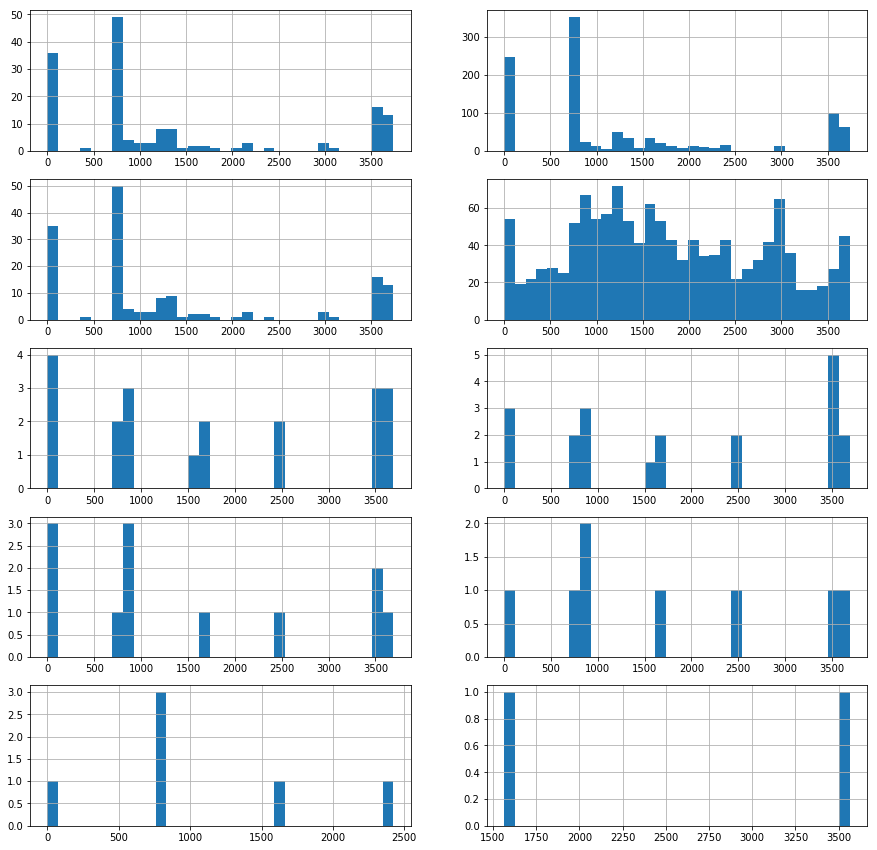

In [29]:
fig,axs = plt.subplots(5,2,figsize=(15,15))
df_class0['scrollY'].hist(ax=axs[0,0],bins=32)
df_class1['scrollY'].hist(ax=axs[0,1],bins=32)
df_class2['scrollY'].hist(ax=axs[1,0],bins=32)
df_class3['scrollY'].hist(ax=axs[1,1],bins=32)
df_class4['scrollY'].hist(ax=axs[2,0],bins=32)
df_class5['scrollY'].hist(ax=axs[2,1],bins=32)
df_class6['scrollY'].hist(ax=axs[3,0],bins=32)
df_class7['scrollY'].hist(ax=axs[3,1],bins=32)
df_class8['scrollY'].hist(ax=axs[4,0],bins=32)
df_class9['scrollY'].hist(ax=axs[4,1],bins=32)

In [30]:
print("Shape of Class 0 : ",df_class0.shape)
print("Shape of Class 1 : ",df_class1.shape)
print("Shape of Class 2 : ",df_class2.shape)
print("Shape of Class 3 : ",df_class3.shape)
print("Shape of Class 4 : ",df_class4.shape)
print("Shape of Class 5 : ",df_class5.shape)
print("Shape of Class 6 : ",df_class6.shape)
print("Shape of Class 7 : ",df_class7.shape)
print("Shape of Class 8 : ",df_class8.shape)
print("Shape of Class 9 : ",df_class9.shape)
print("Shape of Class 10 : ",df_class10.shape)

Shape of Class 0 :  (156, 2)
Shape of Class 1 :  (1036, 2)
Shape of Class 2 :  (157, 2)
Shape of Class 3 :  (1262, 2)
Shape of Class 4 :  (20, 2)
Shape of Class 5 :  (20, 2)
Shape of Class 6 :  (12, 2)
Shape of Class 7 :  (8, 2)
Shape of Class 8 :  (6, 2)
Shape of Class 9 :  (2, 2)
Shape of Class 10 :  (2, 2)


In [31]:
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0['time'].values.reshape(-1,1)
envelope.fit(X_train)
df_class0_temp = pd.DataFrame(df_class0['time'])
df_class0_temp['deviation'] = envelope.decision_function(X_train)
df_class0_temp['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1['time'].values.reshape(-1,1)
envelope.fit(X_train)
df_class1_temp = pd.DataFrame(df_class1['time'])
df_class1_temp['deviation'] = envelope.decision_function(X_train)
df_class1_temp['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2['time'].values.reshape(-1,1)
envelope.fit(X_train)
df_class2_temp = pd.DataFrame(df_class2['time'])
df_class2_temp['deviation'] = envelope.decision_function(X_train)
df_class2_temp['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3['time'].values.reshape(-1,1)
envelope.fit(X_train)
df_class3_temp = pd.DataFrame(df_class3['time'])
df_class3_temp['deviation'] = envelope.decision_function(X_train)
df_class3_temp['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class4['time'].values.reshape(-1,1)
envelope.fit(X_train)
df_class4_temp = pd.DataFrame(df_class4['time'])
df_class4_temp['deviation'] = envelope.decision_function(X_train)
df_class4_temp['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class5['time'].values.reshape(-1,1)
envelope.fit(X_train)
df_class5_temp = pd.DataFrame(df_class5['time'])
df_class5_temp['deviation'] = envelope.decision_function(X_train)
df_class5_temp['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class6['time'].values.reshape(-1,1)
envelope.fit(X_train)
df_class6_temp = pd.DataFrame(df_class6['time'])
df_class6_temp['deviation'] = envelope.decision_function(X_train)
df_class6_temp['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class7['time'].values.reshape(-1,1)
envelope.fit(X_train)
df_class7_temp = pd.DataFrame(df_class7['time'])
df_class7_temp['deviation'] = envelope.decision_function(X_train)
df_class7_temp['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class8['time'].values.reshape(-1,1)
envelope.fit(X_train)
df_class8_temp = pd.DataFrame(df_class8['time'])
df_class8_temp['deviation'] = envelope.decision_function(X_train)
df_class8_temp['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class9['time'].values.reshape(-1,1)
envelope.fit(X_train)
df_class9_temp = pd.DataFrame(df_class9['time'])
df_class9_temp['deviation'] = envelope.decision_function(X_train)
df_class9_temp['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class10['time'].values.reshape(-1,1)
envelope.fit(X_train)
df_class10_temp = pd.DataFrame(df_class10['time'])
df_class10_temp['deviation'] = envelope.decision_function(X_train)
df_class10_temp['anomaly'] = envelope.predict(X_train)

In [32]:
df_class0_temp['anomaly'].value_counts()
df_class0_temp.head()

,time,deviation,anomaly
0,824.55,3.248031,1
12,949.55,3.255992,1
15,961.55,3.256757,1
22,1632.55,3.299939,1
27,1669.55,3.302342,1


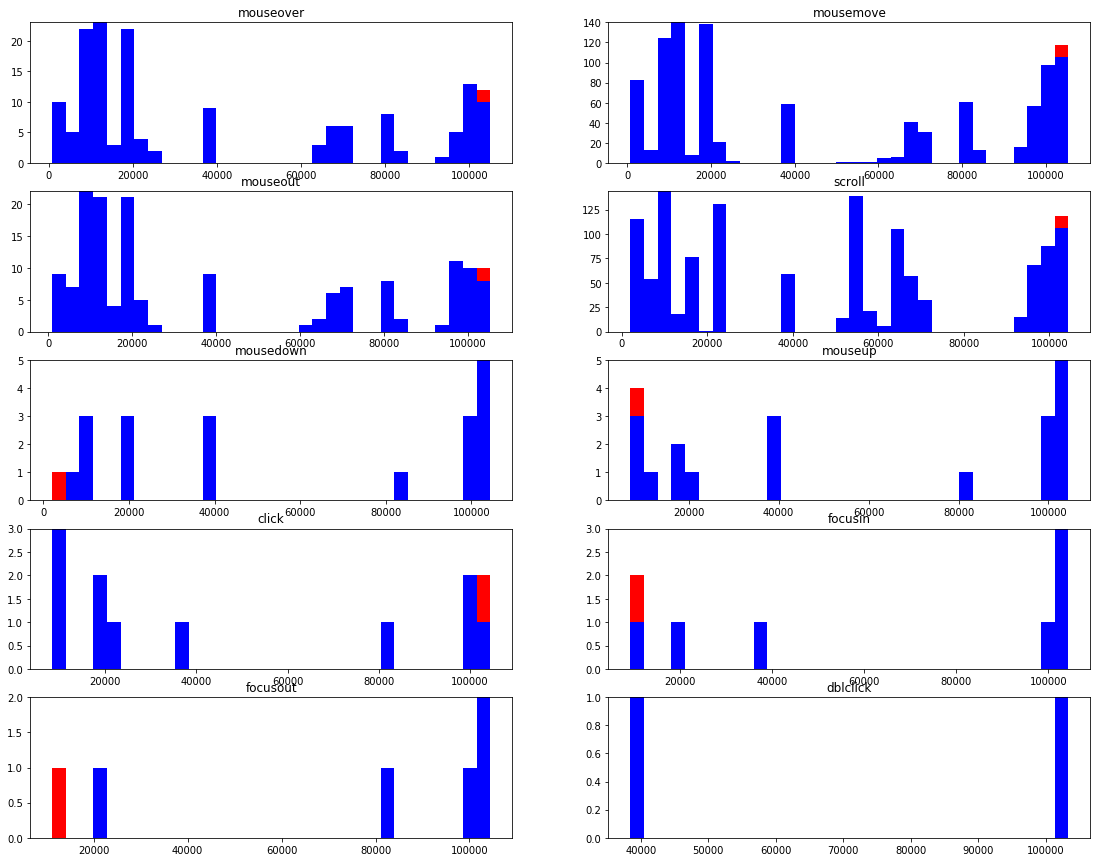

In [33]:
a0 = df_class0_temp.loc[df_class0_temp['anomaly'] == 1, 'time']
b0 = df_class0_temp.loc[df_class0_temp['anomaly'] == -1, 'time']

a1 = df_class1_temp.loc[df_class1_temp['anomaly'] == 1, 'time']
b1 = df_class1_temp.loc[df_class1_temp['anomaly'] == -1, 'time']

a2 = df_class2_temp.loc[df_class2_temp['anomaly'] == 1, 'time']
b2 = df_class2_temp.loc[df_class2_temp['anomaly'] == -1, 'time']

a3 = df_class3_temp.loc[df_class3_temp['anomaly'] == 1, 'time']
b3 = df_class3_temp.loc[df_class3_temp['anomaly'] == -1, 'time']

a4 = df_class4_temp.loc[df_class4_temp['anomaly'] == 1, 'time']
b4 = df_class4_temp.loc[df_class4_temp['anomaly'] == -1, 'time']

a5 = df_class5_temp.loc[df_class5_temp['anomaly'] == 1, 'time']
b5 = df_class5_temp.loc[df_class5_temp['anomaly'] == -1, 'time']

a6 = df_class6_temp.loc[df_class6_temp['anomaly'] == 1, 'time']
b6 = df_class6_temp.loc[df_class6_temp['anomaly'] == -1, 'time']

a7 = df_class7_temp.loc[df_class7_temp['anomaly'] == 1, 'time']
b7 = df_class7_temp.loc[df_class7_temp['anomaly'] == -1, 'time']

a8 = df_class8_temp.loc[df_class8_temp['anomaly'] == 1, 'time']
b8 = df_class8_temp.loc[df_class8_temp['anomaly'] == -1, 'time']

a9 = df_class9_temp.loc[df_class9_temp['anomaly'] == 1, 'time']
b9 = df_class9_temp.loc[df_class9_temp['anomaly'] == -1, 'time']

fig,axs = plt.subplots(5,2,figsize=(19,15))
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[2,0].hist([a4,b4], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[2,1].hist([a5,b5], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[3,0].hist([a6,b6], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[3,1].hist([a7,b7], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[4,0].hist([a8,b8], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[4,1].hist([a9,b9], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])

axs[0,0].set_title("mouseover")
axs[0,1].set_title('mousemove')
axs[1,0].set_title("mouseout")
axs[1,1].set_title('scroll')
axs[2,0].set_title("mousedown")
axs[2,1].set_title('mouseup')
axs[3,0].set_title("click")
axs[3,1].set_title('focusin')
axs[4,0].set_title("focusout")
axs[4,1].set_title('dblclick')

In [34]:
df_class = pd.concat([df_class0_temp,df_class1_temp,df_class2_temp,df_class3_temp,df_class4_temp,df_class5_temp,df_class6_temp,df_class7_temp,df_class8_temp,df_class9_temp,df_class10_temp])
df_ee['anomaly'] = df_class['anomaly']
df_ee['anomaly'] = np.array(df_ee['anomaly'] == -1).astype(int) 

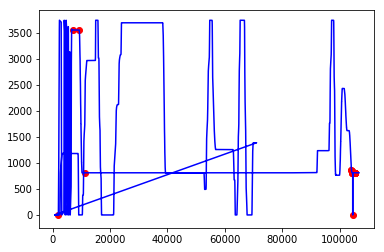

In [36]:
fig, ax = plt.subplots()

a = df_ee.loc[df_ee['anomaly'] == 1, ('time', 'scrollY')] #anomaly

ax.plot(df_ee['time'], df_ee['scrollY'], color='blue')
ax.scatter(a['time'],a['scrollY'], color='red')
plt.show()

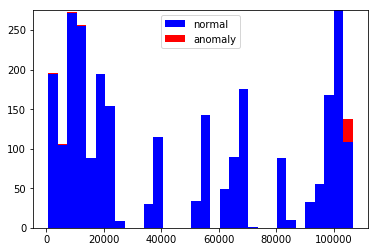

In [38]:
a = df_ee.loc[df_ee['anomaly'] == 0, 'time']
b = df_ee.loc[df_ee['anomaly'] == 1, 'time']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## Isolation Forest :
This algorithm is one more algorithm to identify anomalies. Works well with different data repartition and efficient with high dimention data. Used to detect unordered collective anomalies.

In [39]:
df_isolation = get_data()
df_isolation = add_dummies(df_isolation,types)
df_isolation = assign_dummies(df_isolation,types_dict)
df_isolation = remove_columns(df_isolation,['height','width','scrollX','type'])
X,df_isolation = scale_data(df_isolation)

106672.515 740.435
3740.0 0.0


In [40]:
model =  IsolationForest(contamination = outliers_fraction)
model.fit(df_isolation)

IsolationForest(bootstrap=False, contamination=0.01, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [41]:
df_isolation['anomaly'] = pd.Series(model.predict(df_isolation))
df_isolation['anomaly'] = df_isolation['anomaly'].map({1:0,-1:1})
print(df_isolation['anomaly'].value_counts())

0    2654
1      27
Name: anomaly, dtype: int64


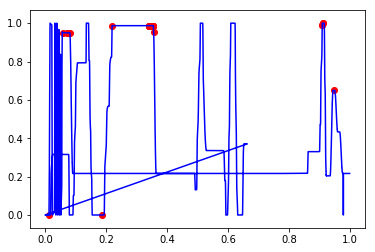

In [42]:
fig, ax = plt.subplots()

a = df_isolation.loc[df_isolation['anomaly'] == 1, ['time', 'scrollY']] #anomaly

ax.plot(df_isolation['time'], df_isolation['scrollY'], color='blue')
ax.scatter(a['time'],a['scrollY'], color='red')
plt.show()

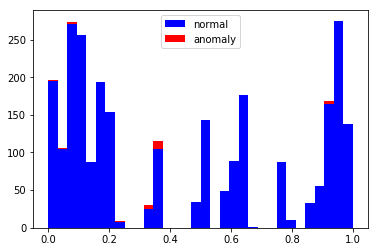

In [43]:
a = df_isolation.loc[df_isolation['anomaly'] == 0, 'time']
b = df_isolation.loc[df_isolation['anomaly'] == 1, 'time']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## One Class Support Vector Machine :
This considers data as single class but assigns non satisfying data as anomalies. Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [44]:
df_svm = get_data()
df_svm = add_dummies(df_svm,types)
df_svm = assign_dummies(df_svm,types_dict)
df_svm = remove_columns(df_svm,['height','width','scrollX','type'])
X,df_svm = scale_data(df_svm)

106672.515 740.435
3740.0 0.0


In [45]:
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
model.fit(df_svm)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.0095, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [46]:
df_svm['anomaly'] = pd.Series(model.predict(df_svm))
df_svm['anomaly'] = df_svm['anomaly'].map({1:0,-1:1})
print(df_svm['anomaly'].value_counts())

0    2655
1      26
Name: anomaly, dtype: int64


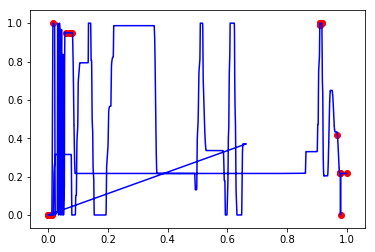

In [47]:
fig, ax = plt.subplots()

a = df_svm.loc[df_svm['anomaly'] == 1, ['time', 'scrollY']] #anomaly

ax.plot(df_svm['time'], df_svm['scrollY'], color='blue')
ax.scatter(a['time'],a['scrollY'], color='red')
plt.show()

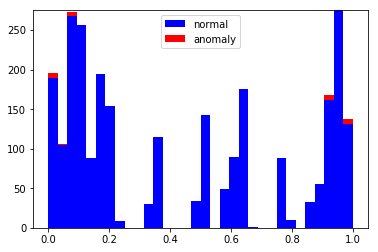

In [48]:
a = df_svm.loc[df_svm['anomaly'] == 0, 'time']
b = df_svm.loc[df_svm['anomaly'] == 1, 'time']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## RNN (LSTM Neural Networks) :
RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.
Here we make learn from 50 previous values, and we predict just the 1 next value. RNNs are used to detect ordered anomalies.

In [49]:
df_rnn = get_data()
df_rnn = add_dummies(df_rnn,types)
df_rnn = assign_dummies(df_rnn,types_dict)
df_rnn = remove_columns(df_rnn,['height','width','scrollX','type'])
X,df_rnn = scale_data(df_rnn)

106672.515 740.435
3740.0 0.0


In [52]:
prediction_time = 1
testdatasize = 400
unroll_length = 50
testdatacut = testdatasize + unroll_length + 1

#Train Data
x_train = df_rnn[0:-prediction_time-testdatacut].values
y_train = df_rnn['time'][prediction_time:-testdatacut ].values
# test data
x_test = df_rnn[0-testdatacut:-prediction_time].values
y_test = df_rnn['time'][prediction_time-testdatacut:  ].values

In [53]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (2179, 50, 13)
y_train (2179,)
x_test (400, 50, 13)
y_test (400,)


In [54]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

Using TensorFlow backend.


In [55]:
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

C:\Users\Ashutosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\Users\Ashutosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, input_shape=(None, 13), return_sequences=True)`
  


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
compilation time : 0.17553234100341797


In [56]:
model.fit(
    x_train,
    y_train,
    batch_size=128,
    nb_epoch=30,
    validation_split=0.15)

C:\Users\Ashutosh\Anaconda3\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1852 samples, validate on 327 samples
Epoch 1/30
1852/1852 [==============================] - 10s - loss: 0.0345 - val_loss: 0.0120
Epoch 2/30
1852/1852 [==============================] - 5s - loss: 0.0075 - val_loss: 0.0923
Epoch 3/30
1852/1852 [==============================] - 5s - loss: 0.0081 - val_loss: 0.0134
Epoch 4/30
1852/1852 [==============================] - 5s - loss: 0.0048 - val_loss: 0.0319
Epoch 5/30
1852/1852 [==============================] - 5s - loss: 0.0054 - val_loss: 0.0357
Epoch 6/30
1852/1852 [==============================] - 5s - loss: 0.0046 - val_loss: 0.0087
Epoch 7/30
1852/1852 [==============================] - 5s - loss: 0.0046 - val_loss: 0.0240
Epoch 8/30
1852/1852 [==============================] - 5s - loss: 0.0035 - val_loss: 0.0084
Epoch 9/30
1852/1852 [==============================] - 5s - loss: 0.0035 - val_loss: 0.0404
Epoch 10/30
1852/1852 [==============================] - 6s - loss: 0.0035 - val_loss: 0.0111
Epoch 11/30
1852/1852

In [57]:
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

In [58]:
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(df_rnn)-testdatasize))
# # add the data to the main
df_rnn['anomaly'] = complement.append(test, ignore_index='True')
print(df_rnn['anomaly'].value_counts())

0    2677
1       4
Name: anomaly, dtype: int64


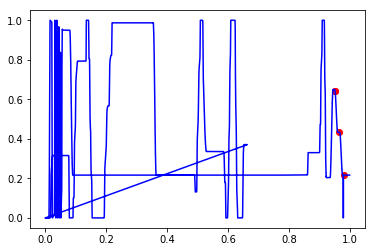

In [59]:
fig, ax = plt.subplots()

a = df_rnn.loc[df_rnn['anomaly'] == 1, ['time', 'scrollY']] #anomaly

ax.plot(df_rnn['time'], df_rnn['scrollY'], color='blue')
ax.scatter(a['time'],a['scrollY'], color='red')
plt.show()

C:\Users\Ashutosh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


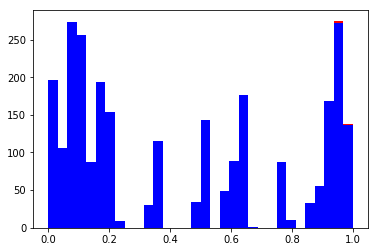

In [60]:
a = df_rnn.loc[df_rnn['anomaly'] == 0, 'time']
b = df_rnn.loc[df_rnn['anomaly'] == 1, 'time']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

## Conclusion : 
In my observation, the anomalies involved in the data is most probably collective anomalies. And among three algorithms to find collective anomalies, One Class SVM is giving the better results in comparison to others. And from that, we can conclude that the data involved is Multi-dimensional Unordered data.